### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [1]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [3]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans

from collections import Counter

pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [5]:
# Load in the general demographics data.
azdias_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';', low_memory=False)
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
# Source https://www.geeksforgeeks.org/pandas-read_csv-low_memory-and-dtype-options/, stalling my notebook
# add low_memory=False to azdias_df

In [6]:
# Loading the customer file here to view what it is now and had lots of integration issues when loaded later
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';', low_memory=False)

In [7]:
print('Azdias_df shape =',azdias_df.shape) 
print('Customers shape =',customers.shape) 
print('Features Summary shape =',feat_info.shape) 

Azdias_df shape = (891221, 85)
Customers shape = (191652, 85)
Features Summary shape = (85, 4)


In [8]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [9]:
azdias_df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,...,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,...,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,...,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,...,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,...,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
azdias_df.duplicated().sum()
# 52,494 rows are duplicates

52494

In [11]:
azdias_df.isna().sum().sum()

4896838

In [12]:
azdias_df.isna().sum().sort_values(ascending=False)
# Nulls are an issue

KK_KUNDENTYP    584612
KBA05_ANTG1     133324
KBA05_ANTG2     133324
KBA05_ANTG3     133324
KBA05_ANTG4     133324
                 ...  
SEMIO_MAT            0
SEMIO_REL            0
SEMIO_FAM            0
SEMIO_SOZ            0
AGER_TYP             0
Length: 85, dtype: int64

In [13]:
feat_info.info()
# No empty fields

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [14]:
feat_info
# No nulls but what is missing_or_unknown column?

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [15]:
# The rows of the feat_info describe columns in the azdias_df dataframe. 

In [16]:
customers.isna().sum()

AGER_TYP                    0
ALTERSKATEGORIE_GROB        0
ANREDE_KZ                   0
CJT_GESAMTTYP            3213
FINANZ_MINIMALIST           0
                        ...  
PLZ8_HHZ                52764
PLZ8_GBZ                52764
ARBEIT                  50476
ORTSGR_KLS9             50476
RELAT_AB                50476
Length: 85, dtype: int64

In [17]:
customers.duplicated().sum()
# 42,418 rows are duplicated

42418

In [18]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,...,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,...,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,...,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,...,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,...,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [19]:
customers.isna().sum().sort_values(ascending=False)
# Nulls will be an issue in this dataframe too

KK_KUNDENTYP    111937
KBA05_BAUMAX     55980
KBA05_ANTG4      55980
KBA05_ANTG3      55980
KBA05_ANTG2      55980
                 ...  
SEMIO_MAT            0
SEMIO_REL            0
SEMIO_FAM            0
SEMIO_SOZ            0
AGER_TYP             0
Length: 85, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [20]:
# Identify missing or unknown data values and convert them to NaNs.
# Splitting the missing_or_unknown column in feat_info & replace those values in the related cols of azdias_df
for row in feat_info.iterrows():
    col = (row[1]['attribute'])
    for i in row[1]['missing_or_unknown'].strip('[').strip(']').split(','):
        if i!='X' and i!='XX' and i!='':
            azdias_df.loc[(azdias_df[col]==int(i)),[col]]=np.nan
        elif i=='':
            azdias_df.loc[(azdias_df[col].isnull()),[col]]=np.nan
        else:
            azdias_df.loc[(azdias_df[col]==i),[col]]=np.nan

In [21]:
azdias_df.isna().sum().sum()
# Source: https://knowledge.udacity.com/questions/334122 - matches the expected count

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [22]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Are the features the same?
cats = feat_info['attribute'].tolist()
cusfeats = customers.columns.tolist()
azdiasfeat = azdias_df.columns.tolist()

In [23]:
azdiasfeat == cats, azdiasfeat == cusfeats
# The columns match

(True, True)

In [24]:
null_count = azdias_df.isnull().sum()
null_count

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [25]:
null_percent = (azdias_df.isnull().sum() / len(azdias_df)) * 100
null_percent

AGER_TYP                76.955435
ALTERSKATEGORIE_GROB     0.323264
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.544646
FINANZ_MINIMALIST        0.000000
                          ...    
PLZ8_HHZ                13.073637
PLZ8_GBZ                13.073637
ARBEIT                  10.926022
ORTSGR_KLS9             10.914689
RELAT_AB                10.926022
Length: 85, dtype: float64

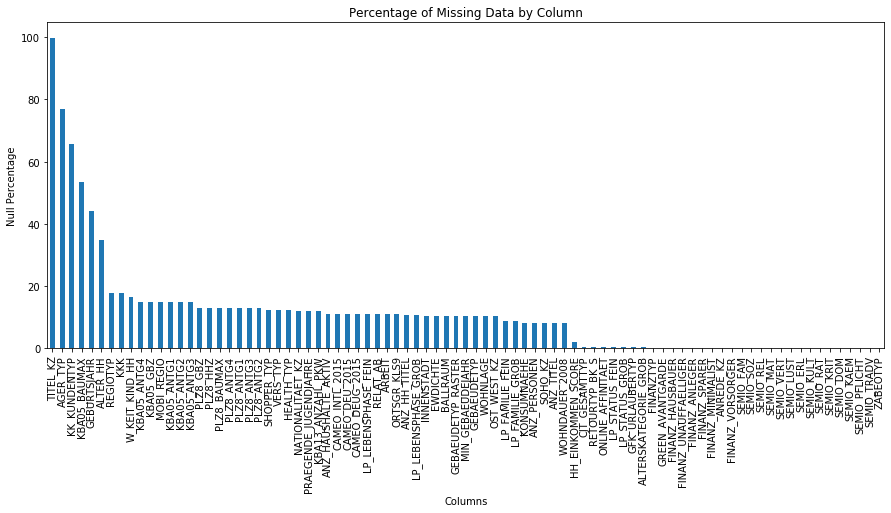

In [26]:
# Investigate patterns in the amount of missing data in each column
null_percent.sort_values(ascending=False).plot(kind='bar', figsize=(15, 6))
plt.title('Percentage of Missing Data by Column')
plt.xlabel('Columns')
plt.ylabel('Null Percentage')
plt.show()

In [27]:
# Adding a column to count the number of missing fields by row
azdias_df['na_count'] = azdias_df.isna().sum(axis=1) 
azdias_df.head(2)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,...,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,na_count
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,NaN,10.0,0.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,1996.0,10.0,0.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5.0,...,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,4


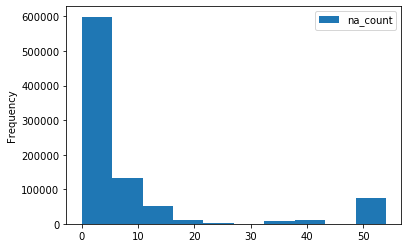

In [28]:
azdias_df.plot.hist(y='na_count')
plt.show()
# Now I can see 30 is a good separation point for labeling as high or low count of missing values

In [29]:
# Dropping the column 'na_count' to avoid issues w features later
azdias_df.pop(azdias_df.columns[-1])
azdias_df.shape

(891221, 85)

In [30]:
# Save the percentage of missing values in each column
azdias_null_mean = azdias_df.isna().mean()
azdias_null_mean = azdias_null_mean.to_frame()

Text(0, 0.5, 'Column Count')

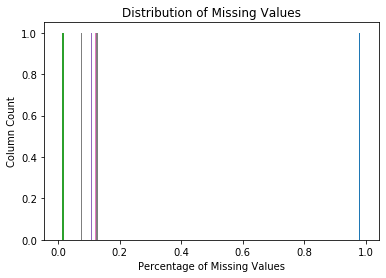

In [31]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(azdias_null_mean, bins = 30)
plt.title('Distribution of Missing Values')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column Count')

In [32]:
# List the columns that are largely null
azdias_hi_missing = azdias_null_mean[azdias_null_mean[0] > 0.3].index.to_list()
azdias_hi_missing

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [33]:
# Repeating on the customers dataframe
cust_null_mean = customers.isna().mean() 
cust_null_mean = cust_null_mean.to_frame() 

In [34]:
# List the columns that are largely null
cust_hi_missing = cust_null_mean[azdias_null_mean[0] > .3].index.to_list()
cust_hi_missing

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [35]:
# Check if the outlier columns are the same in azdias and customers dataframes
azdias_hi_missing == cust_hi_missing
# They are the same and can be droped

True

In [36]:
outlier_cols = ['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [37]:
# Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as 
# re-encoding and imputation later.)
azdias_cleaned = azdias_df.copy()
azdias_cleaned.drop(columns=outlier_cols, inplace=True)
azdias_cleaned.shape # confirming 6 columns less than before, outlier columns deleted

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column
I dropped these 6 columns due to the amount of missing data:
1. AGER_TYP: A "person level" feature that describes the engagement level of the elderly. Approximately 78% of data is missing.
2. GEBURTSJAHR: A "person level" feature that contains year of birth. Approximately 78% of data is missing.
3. TITEL_KZ: A "person level" feature that list their title if they are in academia. All data is missing.
4. ALTER_HH:  A "person level" feature that contains year of birth for the head of household. Approximately 35% of data is missing. 
5. KK_KUNDENTYP: A "head of household" feature that lists their purchase pattern over the previous 12 months. Approximately 65% of data is missing.
6. KBA05_BAUMAX: A "microcell feature" indicating the building type within the smaller network. Approximately 53% of data is missing.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [38]:
azdias_null = azdias_cleaned.isnull().sum(axis=1)/azdias_cleaned.shape[1]
azdias_null_df = pd.DataFrame({'NaNs':azdias_null})
azdias_null_df

,NaNs
0,0.544304
1,0.000000
2,0.000000
3,0.088608
4,0.000000
...,...
891216,0.037975
891217,0.050633
891218,0.063291
891219,0.000000


In [39]:
# How much data is missing in each row of the dataset?
# percent of rows with missing data
azdias_null_df[azdias_null_df['NaNs'] != 0].shape[0] / azdias_cleaned.shape[0]

0.3007245116531141

In [40]:
# How much data is missing in each row of the dataset?
missing_row_vals = azdias_cleaned.isnull().sum() / len(azdias_cleaned) * 100  # Percentage of missing values
missing_row_vals.sort_values(ascending=False)
# including here because may be useful later in determining which columns were dropped

KKK               17.735668
REGIOTYP          17.735668
W_KEIT_KIND_HH    16.605084
MOBI_REGIO        14.959701
KBA05_ANTG4       14.959701
                    ...    
SEMIO_LUST         0.000000
SEMIO_VERT         0.000000
SEMIO_MAT          0.000000
SEMIO_REL          0.000000
ZABEOTYP           0.000000
Length: 79, dtype: float64

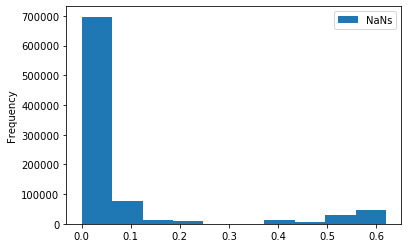

In [41]:
azdias_null_df.plot.hist(y='NaNs')
plt.show()

In [42]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
lo_missing = azdias_null_df[azdias_null_df['NaNs'] < .225].index.to_list()
hi_missing = azdias_null_df[azdias_null_df['NaNs'] > .225].index.to_list()

In [43]:
lo_count = len(lo_missing)
hi_count = len(hi_missing)

In [44]:
total = lo_count + hi_count
total
# Equals the count of azdias_null_df

891221

In [45]:
lo_count_df = azdias_cleaned.iloc[lo_missing]
lo_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795469 entries, 1 to 891220
Data columns (total 79 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   792713 non-null  float64
 1   ANREDE_KZ              795469 non-null  float64
 2   CJT_GESAMTTYP          790954 non-null  float64
 3   FINANZ_MINIMALIST      795469 non-null  float64
 4   FINANZ_SPARER          795469 non-null  float64
 5   FINANZ_VORSORGER       795469 non-null  float64
 6   FINANZ_ANLEGER         795469 non-null  float64
 7   FINANZ_UNAUFFAELLIGER  795469 non-null  float64
 8   FINANZ_HAUSBAUER       795469 non-null  float64
 9   FINANZTYP              795469 non-null  float64
 10  GFK_URLAUBERTYP        790954 non-null  float64
 11  GREEN_AVANTGARDE       795469 non-null  float64
 12  HEALTH_TYP             759299 non-null  float64
 13  LP_LEBENSPHASE_FEIN    746280 non-null  float64
 14  LP_LEBENSPHASE_GROB    749084 non-nu

In [46]:
len(lo_missing) / len(azdias_null_df)

0.8925608799613115

In [47]:
hi_count_df = azdias_cleaned.iloc[hi_missing]
hi_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95752 entries, 0 to 891187
Data columns (total 79 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ALTERSKATEGORIE_GROB   95627 non-null  float64
 1   ANREDE_KZ              95752 non-null  float64
 2   CJT_GESAMTTYP          95413 non-null  float64
 3   FINANZ_MINIMALIST      95752 non-null  float64
 4   FINANZ_SPARER          95752 non-null  float64
 5   FINANZ_VORSORGER       95752 non-null  float64
 6   FINANZ_ANLEGER         95752 non-null  float64
 7   FINANZ_UNAUFFAELLIGER  95752 non-null  float64
 8   FINANZ_HAUSBAUER       95752 non-null  float64
 9   FINANZTYP              95752 non-null  float64
 10  GFK_URLAUBERTYP        95413 non-null  float64
 11  GREEN_AVANTGARDE       95752 non-null  float64
 12  HEALTH_TYP             20726 non-null  float64
 13  LP_LEBENSPHASE_FEIN    47309 non-null  float64
 14  LP_LEBENSPHASE_GROB    47565 non-null  float64
 15  L

In [48]:
len(hi_count_df) / len(azdias_null_df)

0.1074391200386885

In [49]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols_for_compare = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_UNAUFFAELLIGER', 'SEMIO_RAT', 'ZABEOTYP', ]

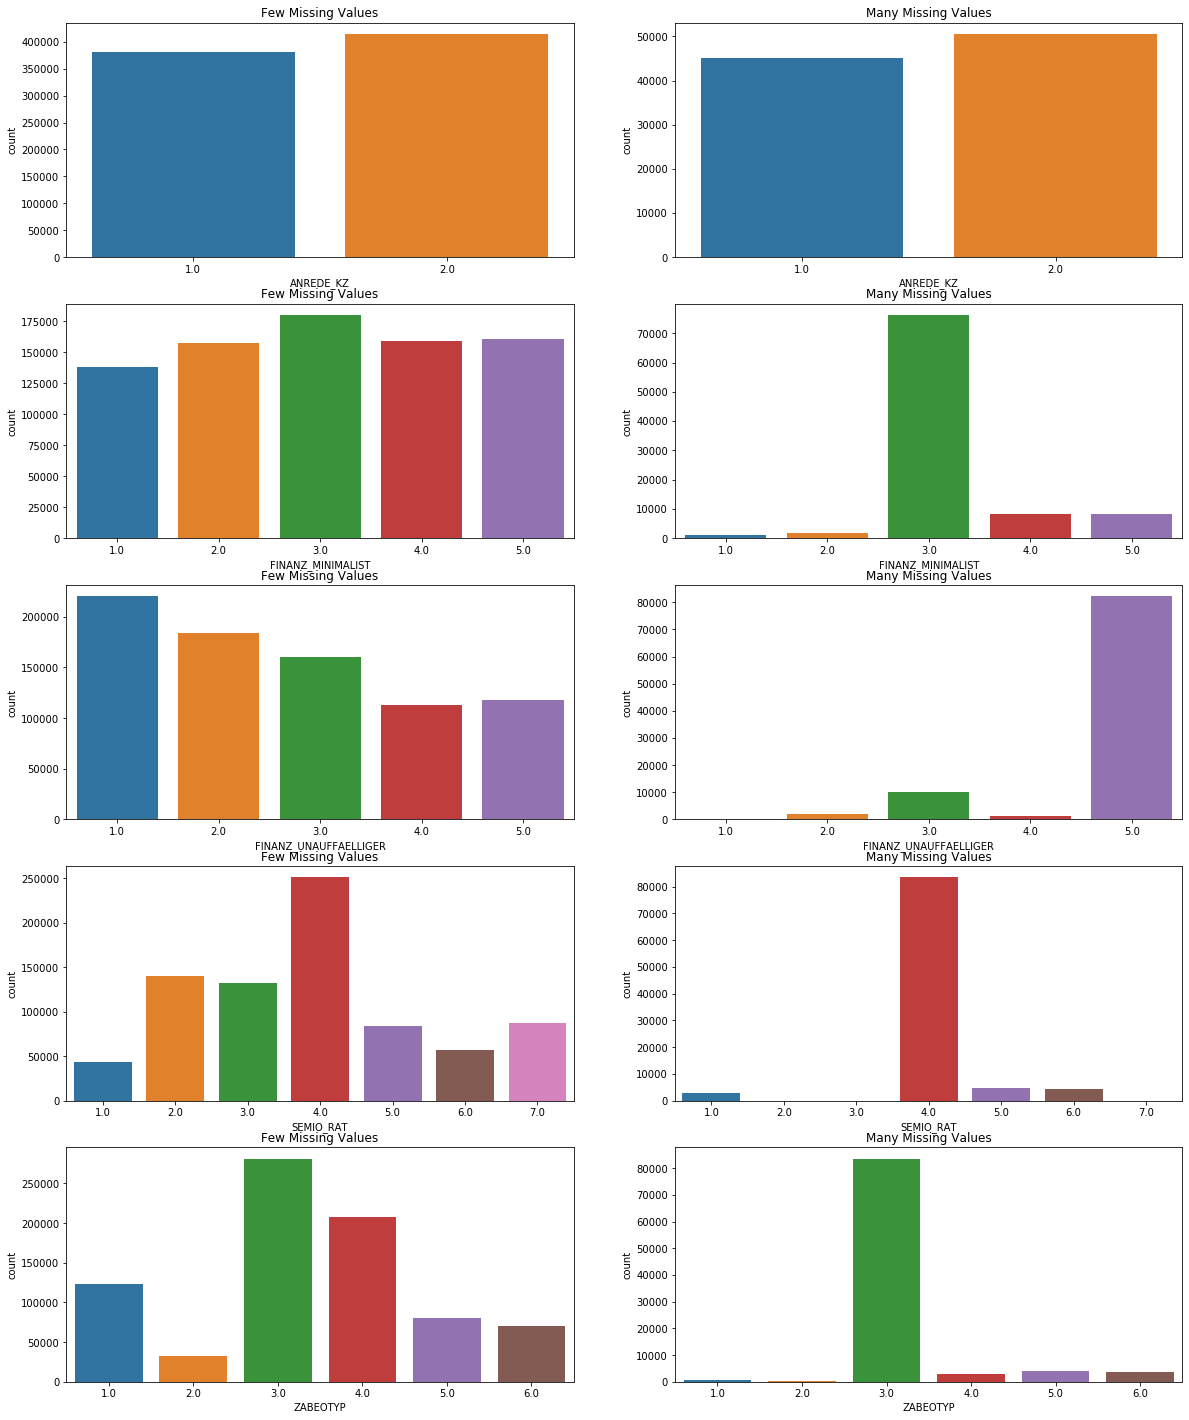

In [50]:
def compare_plots(cols, num=5, lo_count_df=None, hi_count_df=None): #Added the dataframes as parameters.
    fig, axs = plt.subplots(num, 2, figsize=(20, 25))
    axs = axs.ravel()
    for i in range(num):
        sns.countplot(x=cols[i], data=lo_count_df, ax=axs[i * 2]) 
        axs[i * 2].set_title('Few Missing Values')

        sns.countplot(x=cols[i], data=hi_count_df, ax=axs[i * 2 + 1]) 
        axs[i * 2 + 1].set_title('Many Missing Values')

compare_plots(cols=cols_for_compare, num=5, lo_count_df=lo_count_df, hi_count_df=hi_count_df)
# Source to convert for newer versions of Seaborn: Google AI. Gemini, gemini.google.com

#### Discussion 1.1.3: Assess Missing Data in Each Row

Approximately 11% of rows are missing more than 22 values from the columns. According to the histogram, 22 seems to be a strong dividing point for defining high amounts of missing data from lower amounts. Then I selected five columns to compare between the datasets. ANREDE_KZ is consistent between the two datasets with female ("2") being the larger portion in each set. Those with low financial interest, FINANZ_MINIMALIST, mimic each other between the sets but to varying degrees. The populations with average, low and very low are represented consistently but while retaining their rank, the highs are drastically underrepresented in one set. The inconspicuous spenders, FINANZ_UNAUFFAELLIGER, completely diverge between the datasets. For the SEMIO_RAT, or those with a rational personality, those declared with an average affinity is consistently distributed but none of the other categories are. Finally, ZABEOTYP groups, or the energy motivation behind purchases is the same for "fair supplied" group only. I am not comfortable deleting these with the inconsistencies.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [51]:
lo_count_df.shape[0] / azdias_cleaned.shape[0]
# 89% of rows in azdias are in the low count dataframe

0.8925608799613115

In [52]:
# How many features are there of each data type?
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [53]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Per instructions, "data should only be from the subset with few or no missing values"
cats = lo_count_df.columns.to_list()
feat_info_lo = feat_info[feat_info['attribute'].isin(cats)]
feat_info_lo.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [54]:
feat_info_lo[feat_info_lo['type'] == 'categorical']

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [55]:
# Set categorical variables as a list
cat_var = lo_count_df[feat_info_lo[feat_info_lo['type'] == 'categorical']['attribute']]
cat_var

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2.0,5.0,1.0,10.0,0.0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5.0,8.0,W,8,8A
2,2.0,3.0,1.0,10.0,1.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5.0,1.0,W,4,4C
3,2.0,2.0,6.0,1.0,0.0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3.0,1.0,W,2,2A
4,1.0,5.0,5.0,5.0,0.0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4.0,1.0,W,6,6B
5,2.0,2.0,2.0,1.0,0.0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4.0,1.0,W,8,8C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,2.0,5.0,1.0,12.0,0.0,1.0,1.0,2.0,1.0,1.0,3.0,0.0,1.0,4.0,8.0,W,7,7A
891217,1.0,4.0,6.0,1.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,NaN,6.0,8.0,W,9,9D
891218,2.0,4.0,1.0,10.0,0.0,NaN,NaN,4.0,2.0,1.0,2.0,0.0,1.0,4.0,8.0,W,4,4C
891219,1.0,3.0,1.0,9.0,0.0,9.0,5.0,2.0,1.0,1.0,0.0,0.0,2.0,5.0,8.0,W,9,9D


In [56]:
# Separate the categorical variables into binary or multi-variable
binary = []
multivar = []

for x in cat_var:
    if len(cat_var[x].value_counts()) == 2:
        binary.append(x)
    else:
        multivar.append(x)

In [57]:
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [58]:
multivar

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [59]:
# values for binary data
for x in binary:
    print(x, lo_count_df[x].unique())

ANREDE_KZ [2. 1.]
GREEN_AVANTGARDE [0. 1.]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
OST_WEST_KZ ['W' 'O']


In [60]:
# Convert values of column OST_WEST_KZ to numbers
lo_count_df['OST_WEST_KZ'] = lo_count_df['OST_WEST_KZ'].map({'W': 1, 'O': 0})

/Users/jenniferkrohn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
# values for multivariate data
for x in multivar:
    print(x, lo_count_df[x].unique())

CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP [1. 6. 5. 2. 4. 3.]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ [ 1.  3.  2. nan]
SHOPPER_TYP [ 3.  2.  1.  0. nan]
ZABEOTYP [5. 3. 4. 1. 6. 2.]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']


In [62]:
# Re-encode categorical variable(s) to be kept in the analysis.
# After much experimentation, I decided to do less wrangling on the columns at this point to avoid conflict with
# the Customers dataframe later
lo_count_df = pd.get_dummies(lo_count_df, columns = multivar)

In [63]:
lo_count_df.shape

(795469, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features
After much experimentation, I learned that using PCA to all dataframes is the most reliable way to address missing data. But the OST_WEST_KZ data needed to be encoded to an integer to avoid issues later. The multivariable data are integers, or missing, except for the CAMEO columns. These will be addressed later. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [64]:
feat_info_lo[feat_info_lo['type'] == 'mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#### The dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
The Data Dictionary defines as Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west). This is the data dictionary list rearranged by Mainstream vs Avantgarde

Mainstream:
-  1: 40s - war years (Mainstream, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  8: 70s - family orientation (Mainstream, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 14: 90s - digital media kids (Mainstream, E+W)

Avantgarde:
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  9: 70s - peace movement (Avantgarde, E+W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Unknown or missing:
- -1: unknown
-  0: unknown


In [65]:
mainstream = {
    # below values are mainstream
    2: 0,
    4: 0,
    6: 0,
    7: 0,
    9: 0,
    11: 0,
    13: 0,
    15: 0,
   # below values are avantegard     
    1: 1,
    3: 1,
    5: 1,
    8: 1,
    10: 1,
    12: 1,
    14: 1,
    # below are NaNs
    0: np.nan,
    np.nan: np.nan
}

In [66]:
lo_count_df['YOUTH_TASTE'] = lo_count_df['PRAEGENDE_JUGENDJAHRE'].map(mainstream)
lo_count_df.shape

(795469, 195)

In [67]:
decade = {
    1: '40s',
    2: '40s', 
    3: '50s', 
    4: '50s',
    5: '60s',
    6: '60s',
    7: '60s',
    8: '70s',
    9: '70s',
    10: '80s',
    11: '80s',
    12: '80s',
    13: '80s',
    14: '90s',
    15: '90s',
    0: np.nan,
    np.nan: np.nan
}

In [68]:
lo_count_df['DECADE'] = np.nan
lo_count_df['DECADE'] = lo_count_df['PRAEGENDE_JUGENDJAHRE'].map(decade)
lo_count_df.shape

(795469, 196)

### Investigate "CAMEO_INTL_2015" and engineer two new variables. 
From the Data Dictionary - 
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [69]:
wealth_dict = {11: 'WEALTHY', 12: 'WEALTHY', 13: 'WEALTHY', 14: 'WEALTHY', 15: 'WEALTHY',
               21: 'PROSPEROUS',22: 'PROSPEROUS',23: 'PROSPEROUS',24: 'PROSPEROUS',25: 'PROSPEROUS',
               31: 'COMFORTABLE',32: 'COMFORTABLE',33: 'COMFORTABLE',34: 'COMFORTABLE',35: 'COMFORTABLE',
               41: 'LOWER',42: 'LOWER',43: 'LOWER',44: 'LOWER',45: 'LOWER',
               51: 'POOR',52: 'POOR',53: 'POOR',54: 'POOR',55: 'POOR',
               np.nan: np.nan,
               0: np.nan
              }

In [70]:
lo_count_df['WEALTH'] = np.nan
lo_count_df['WEALTH'] = lo_count_df['CAMEO_INTL_2015'].map(wealth_dict)
lo_count_df.shape

(795469, 197)

In [71]:
# The lifestyles within each type of household:
# _1 Pre-Family Couples & Singles
# _2 Young Couples With Children
# _3 Families With School Age Children
# _4 Older Families &  Mature Couples
# _5 Elders In Retirement
lifestage = []

for x in lo_count_df['CAMEO_INTL_2015']:
    if float(x) % 10 == 1:
        lifestage.append("PRE")
    elif float(x) % 10 == 2:
        lifestage.append('YOUNG')
    elif float(x) % 10 == 3:
        lifestage.append('PRI')
    elif float(x) % 10 == 4:
        lifestage.append('OLDER')
    elif float(x) % 10 == 5:
        lifestage.append('ELDERLY')
    else:
        lifestage.append(np.nan)

In [72]:
lifestage = pd.Series(lifestage)
lo_count_df['LIFE_STAGE'] = np.nan
lo_count_df['LIFE_STAGE'] = lifestage.values

In [73]:
lo_count_df['LIFE_STAGE']

1           PRE
2         OLDER
3         YOUNG
4           PRI
5         OLDER
          ...  
891216      PRE
891217      PRE
891218    OLDER
891219      PRE
891220      PRI
Name: LIFE_STAGE, Length: 795469, dtype: object

#### WOHNLAGE
Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood

In [74]:
neighborhood = {
    1: np.nan,
    0: np.nan,
    np.nan: np.nan,
    1: 'very good',
    2: 'good',
    3: 'average',
    4: 'poor',
    5: 'very poor',
    7: 'rural',
    8: 'new rural bldg'
}

In [75]:
lo_count_df['NEIGHBORHOOD'] = np.nan
lo_count_df['NEIGHBORHOOD'] = lo_count_df['WOHNLAGE'].map(neighborhood)

In [76]:
lo_count_df.shape

(795469, 199)

#### PLZ8_BAUMAX
Most common building type within the PLZ8 region per the Data Dictionary:
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings

In [77]:
# PLZ8 values mapping
bldg_type = {    
    1: np.nan,
    0: np.nan,
    np.nan: np.nan,
    1: '1-2 family',
    2: '3-5 family',
    3: '6-10 family',
    4: '10+ family',
    5: 'businesses'
}

In [78]:
lo_count_df['BLDG_TYPE'] = lo_count_df['PLZ8_BAUMAX'].map(bldg_type)

In [79]:
lo_count_df.shape

(795469, 200)

In [80]:
mix_features = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB',
                'PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015', 'WOHNLAGE','PLZ8_BAUMAX']
lo_count_df = pd.get_dummies(lo_count_df, columns=['NEIGHBORHOOD', 'WEALTH', "DECADE", 'BLDG_TYPE','LIFE_STAGE'])

In [81]:
lo_count_df.shape

(795469, 218)

In [82]:
# Drop the columns that have been encoded
lo_count_df = lo_count_df.drop(mix_features,axis=1)

In [83]:
lo_count_df.shape
# Confirmed that the 6 columns have been dropped

(795469, 212)

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this section, I addressed the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns. Each was split into two new columns and then orginal columns were removed from the dataframe. Finally details about the residential neighborhood and buidling types were re-encoded. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [84]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for row in feat_info.iterrows():
        col = (row[1]['attribute'])
        for i in row[1]['missing_or_unknown'].strip('[').strip(']').split(','):
            if i!='X' and i!='XX' and i!='':
                df.loc[(df[col]==int(i)),[col]]=np.nan
            elif i=='':
                df.loc[(df[col].isnull()),[col]]=np.nan
            else:
                df.loc[(df[col]==i),[col]]=np.nan
            
    # create dataframe that holds mean values need to run this again and try deleting eff 3/16
    #df_col_nan_mean = df.isna().mean()
    #df_col_nan_mean = df_col_nan_mean.to_frame()
    
    # remove selected columns and rows, ...
    # create copy of dataframe and then drop columns
    df_clean = df.copy()
    df_clean.drop(columns=outlier_cols, inplace=True) 
    
    # Find rows with little missing data                   
    blank_rows = pd.DataFrame(df_clean.isnull().sum(axis=1) / df_clean.shape[1],columns=['NaNs'])
    low_blank_index = blank_rows[blank_rows['NaNs'] < .225].index.to_list()
    
    # setting clean dataframe to have the values of the low missing data and resetting the index
    df_clean = df_clean.iloc[low_blank_index]
    df_clean.reset_index(inplace=True)

    # select, re-encode, and engineer column values.
    # Divide binary and multivariables data types 
    binary = []
    multivar = []
    for x in cat_var:
        if len(cat_var[x].value_counts()) == 2:
            binary.append(x)
        else:
            multivar.append(x)
            
    # Categorical 
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].map({'W': 1, 'O': 0})
    
    # Encode multivariablse 
    df_clean = pd.get_dummies(df_clean, columns = multivar)
    
    # Set up a youth taste col from PRAEGENDE_JUGENDJAHRE column
    df_clean['YOUTH_TASTE'] = np.nan 
    df_clean['YOUTH_TASTE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(mainstream)
    
    # Set up decade col from 'PRAEGENDE_JUGENDJAHRE' column
    df_clean['DECADE'] = np.nan
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].map(decade)
    
    # Set up wealth col from 'CAMEO_INTL_2015'
    df_clean['WEALTH'] = np.nan
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015'].map(wealth_dict) 
    
    # Map by the stage of life
    cameo_lifestage = []

    for x in df_clean['CAMEO_INTL_2015']:
        if float(x) % 10 == 1:
            cameo_lifestage.append("PREFAM")
        elif float(x) % 10 == 2:
            cameo_lifestage.append('YOUNGFAM')
        elif float(x) % 10 == 3:
            cameo_lifestage.append('PRIMARYFAM')
        elif float(x) % 10 == 4:
            cameo_lifestage.append('OLDERFAM')
        elif float(x) % 10 == 5:
            cameo_lifestage.append('ELDERLY')
        else:
            cameo_lifestage.append(np.nan)
            
    # Fill lifestage values        
    cl = pd.Series(cameo_lifestage)
    df_clean['LIFE_STAGE'] = np.nan
    df_clean['LIFE_STAGE'] = cl.values
    
    # Set neighborhood quality col from the WOHNLAGE column
    df_clean['NEIGHBORHOOD'] = np.nan
    df_clean['NEIGHBORHOOD'] = df_clean['WOHNLAGE'].map(neighborhood)
    
    # Property type from PLZ_BAUMAX column
    df_clean['BLDG_TYPE'] = np.nan
    df_clean['BLDG_TYPE'] = df_clean['PLZ8_BAUMAX'].map(bldg_type)
    
    # Create dummies for the engineered features
    df_clean = pd.get_dummies(df_clean, columns=['NEIGHBORHOOD', 'WEALTH', "DECADE", 'BLDG_TYPE','LIFE_STAGE'])
    
    # Drop features from analysis and mix_features
    df_clean = df_clean.drop(mix_features,axis=1)
    
    # Return the cleaned dataframe.
    return df_clean  

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [85]:
lo_count_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,...,CAMEO_DEU_2015_9E,YOUTH_TASTE,NEIGHBORHOOD_average,NEIGHBORHOOD_good,NEIGHBORHOOD_new rural bldg,NEIGHBORHOOD_poor,NEIGHBORHOOD_rural,NEIGHBORHOOD_very good,NEIGHBORHOOD_very poor,DECADE_40s,DECADE_50s,DECADE_60s,DECADE_70s,DECADE_80s,DECADE_90s,BLDG_TYPE_1-2 family,BLDG_TYPE_10+ family,BLDG_TYPE_3-5 family,BLDG_TYPE_6-10 family,BLDG_TYPE_businesses,LIFE_STAGE_ELDERLY,LIFE_STAGE_OLDER,LIFE_STAGE_PRE,LIFE_STAGE_PRI,LIFE_STAGE_YOUNG
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,...,0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,...,0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,...,0,1.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,...,0,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,...,0,1.0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [86]:
# copy dataframe in case encounter issues later
lo_count_df_cc = lo_count_df.copy()

In [87]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and do that now.
imputer = SimpleImputer(strategy='mean')
azdias_imputed = pd.DataFrame(imputer.fit_transform(lo_count_df), columns = lo_count_df.columns)

In [88]:
azdias_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,...,CAMEO_DEU_2015_9E,YOUTH_TASTE,NEIGHBORHOOD_average,NEIGHBORHOOD_good,NEIGHBORHOOD_new rural bldg,NEIGHBORHOOD_poor,NEIGHBORHOOD_rural,NEIGHBORHOOD_very good,NEIGHBORHOOD_very poor,DECADE_40s,DECADE_50s,DECADE_60s,DECADE_70s,DECADE_80s,DECADE_90s,BLDG_TYPE_1-2 family,BLDG_TYPE_10+ family,BLDG_TYPE_3-5 family,BLDG_TYPE_6-10 family,BLDG_TYPE_businesses,LIFE_STAGE_ELDERLY,LIFE_STAGE_OLDER,LIFE_STAGE_PRE,LIFE_STAGE_PRI,LIFE_STAGE_YOUNG
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,1.0,3.0,3.0,4.0,4.0,6.0,3.0,4.0,7.0,7.0,7.0,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,1.0,2.0,1.0,4.0,4.0,7.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,5.0,6.0,4.0,4.0,2.0,7.0,4.0,4.0,6.0,2.0,3.0,2.0,2.0,4.0,2.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,3.0,2.0,4.0,7.0,4.0,2.0,2.0,2.0,5.0,7.0,4.0,4.0,4.0,7.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [89]:
azdias_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795469 entries, 0 to 795468
Columns: 212 entries, ALTERSKATEGORIE_GROB to LIFE_STAGE_YOUNG
dtypes: float64(212)
memory usage: 1.3 GB


In [90]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_imputed_scale = pd.DataFrame(scaler.fit_transform(azdias_imputed), columns = lo_count_df.columns)

In [91]:
azdias_imputed_scale.shape
# 212 cols at this point

(795469, 212)

### Discussion 2.1: Apply Feature Scaling

I chose to use the mean of each column to fill remaining blanks as I feared mode would skew the data. I used the StandardScaler function as suggested to scale each feature to mean 0 and standard deviation 1. The aim is to standardize the features and the outliers have already been addressed. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [92]:
# Apply PCA to the data.
pca = PCA()
azdias_low_pca = pca.fit_transform(azdias_imputed_scale)
# Source https://knowledge.udacity.com/questions/334125
# Source: https://www.machinelearningplus.com/machine-learning/principal-components-analysis-pca-better-explained/

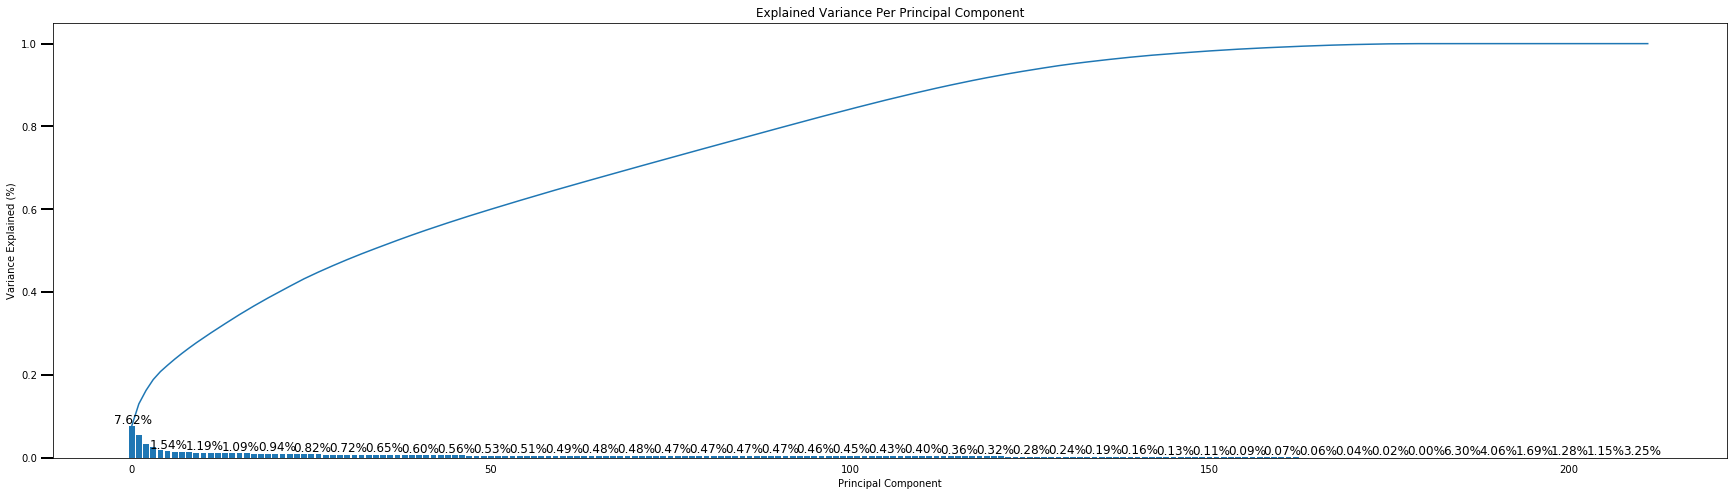

In [93]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(30, 8)) 
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components): 
        if(i%5==0):
            ax.annotate(r'%s%%' % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va='bottom', ha='center', fontsize=12)
        
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)
# Source: https://knowledge.udacity.com/questions/334125

In [94]:
np.cumsum(pca.explained_variance_ratio_)

array([0.07622941, 0.13017249, 0.16272684, 0.18888537, 0.20808454,
       0.22355485, 0.23830194, 0.25213837, 0.26521719, 0.2777598 ,
       0.28967336, 0.30128739, 0.31264772, 0.32377576, 0.33476321,
       0.34571031, 0.35620884, 0.36644986, 0.37632902, 0.38612808,
       0.39554632, 0.40486441, 0.41410218, 0.42327236, 0.43225654,
       0.4405272 , 0.44850349, 0.45625667, 0.46384561, 0.47126052,
       0.47852566, 0.48560017, 0.49248741, 0.49922831, 0.50578299,
       0.51232775, 0.51881125, 0.52522929, 0.53155758, 0.53776801,
       0.54385473, 0.54984521, 0.55569292, 0.56153808, 0.56726144,
       0.57291304, 0.57849251, 0.5840346 , 0.58945298, 0.5948034 ,
       0.6001274 , 0.60542557, 0.6107063 , 0.61593557, 0.62110228,
       0.62625575, 0.63140659, 0.6365289 , 0.64160574, 0.64663098,
       0.65161297, 0.65655694, 0.66148593, 0.66639926, 0.67129353,
       0.67617732, 0.68105672, 0.68592341, 0.69077226, 0.69560742,
       0.70043261, 0.70525644, 0.710074  , 0.71487801, 0.71966

In [95]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 212) 
#pca = PCA(n_components = 120) 
azdias_low_pca = pca.fit_transform(azdias_imputed_scale) 

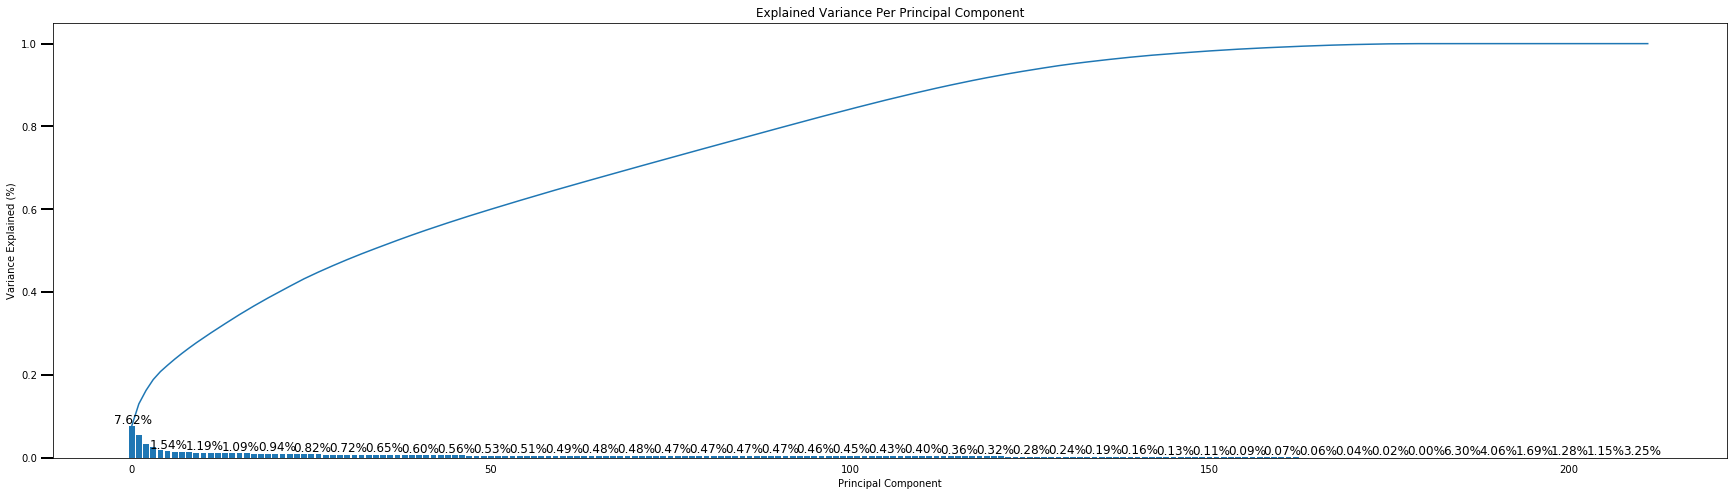

In [96]:
scree_plot(pca)

In [98]:
# delete if next cell resolves issue at end
#X_pca = pca.fit_transform(azdias_imputed_scale)

In [99]:
pca = PCA(n_components = 212)
#pca = PCA(n_components = 120)
pca = pca.fit(azdias_imputed_scale)
X_pca = pca.fit_transform(azdias_imputed_scale)

In [100]:
X_pca
# confirmed an array

array([[ 4.56890872e+00, -4.24148583e+00, -3.16122248e+00, ...,
         4.83836674e-14, -2.02839105e-14, -8.28475608e-16],
       [-6.07611722e-01, -8.69974924e-01, -3.21354368e+00, ...,
         1.19586863e-14,  3.36762860e-14, -7.36471774e-16],
       [-5.13463535e+00,  1.67000832e+00, -1.56795971e+00, ...,
        -1.86655992e-14,  4.75264362e-16, -2.20870871e-15],
       ...,
       [-1.36262089e+00, -4.28187562e+00, -3.60091854e+00, ...,
        -2.09937995e-16,  1.79155985e-16,  1.36053416e-17],
       [ 6.74282796e+00, -4.60085011e+00,  2.85883889e+00, ...,
         1.81258175e-17, -2.14030104e-17,  1.24034920e-17],
       [ 3.36816421e-01,  2.34260954e+00,  1.56119004e+00, ...,
        -3.36768917e-16, -1.58414667e-16, -1.25554326e-17]])

### Discussion 2.2: Perform Dimensionality Reduction

I used 120 for the number of components because the curve levels at about that point.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [101]:
# Need a 1D object for index 
azdias_imputed_scale.cols = azdias_imputed_scale.columns

/Users/jenniferkrohn/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [102]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the other cells.
def print_component(pca, comp):
    if comp <= len(pca.components_):
        weight_df = pd.DataFrame({'WEIGHT': pca.components_[comp]}, index=azdias_imputed_scale.cols)
        print("Highest weighted features for the component ", comp)
        print (weight_df['WEIGHT'])
    else:
        print('That is not the right input.')

print_component(pca, 0)
# Source: https://knowledge.udacity.com/questions/249880

Highest weighted features for the component  0
ALTERSKATEGORIE_GROB   -0.074186
ANREDE_KZ               0.012695
FINANZ_MINIMALIST      -0.179607
FINANZ_SPARER           0.103490
FINANZ_VORSORGER       -0.074777
                          ...   
LIFE_STAGE_ELDERLY     -0.018420
LIFE_STAGE_OLDER       -0.060084
LIFE_STAGE_PRE          0.138590
LIFE_STAGE_PRI         -0.054620
LIFE_STAGE_YOUNG       -0.034540
Name: WEIGHT, Length: 212, dtype: float64


In [103]:
def print_component(pca, comp):
    df = pd.DataFrame({ 'FEATURE': azdias_imputed_scale.columns ,'WEIGHT'+str(comp): pca.components_[comp]})
    df['weight'] = df['WEIGHT'+str(comp)].abs()  
    df = df.sort_values(by=['weight'], ascending=False)
    df = df[['FEATURE', 'WEIGHT'+str(comp)]]
    return df
# Source: https://knowledge.udacity.com/questions/249880

In [104]:
print_component(pca, 0)

,FEATURE,WEIGHT0
47,MOBI_REGIO,-0.199682
110,LP_STATUS_GROB_1.0,0.189658
37,KBA05_ANTG1,-0.186180
53,PLZ8_ANTG3,0.184832
51,PLZ8_ANTG1,-0.184809
...,...,...
81,GFK_URLAUBERTYP_10.0,-0.001580
200,DECADE_80s,0.001469
171,CAMEO_DEU_2015_6D,0.001458
132,GEBAEUDETYP_5.0,0.000362


In [105]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_component(pca, 1)

,FEATURE,WEIGHT1
0,ALTERSKATEGORIE_GROB,0.232927
3,FINANZ_SPARER,-0.230457
4,FINANZ_VORSORGER,0.220746
6,FINANZ_UNAUFFAELLIGER,-0.215818
13,SEMIO_REL,-0.212334
...,...,...
184,CAMEO_DEU_2015_9B,0.000823
112,LP_STATUS_GROB_3.0,0.000810
168,CAMEO_DEU_2015_6A,-0.000761
132,GEBAEUDETYP_5.0,0.000268


In [106]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_component(pca, 2)

,FEATURE,WEIGHT2
1,ANREDE_KZ,-0.338090
15,SEMIO_VERT,0.314418
22,SEMIO_KAEM,-0.307429
21,SEMIO_DOM,-0.273523
20,SEMIO_KRIT,-0.264089
...,...,...
162,CAMEO_DEU_2015_5A,0.000405
173,CAMEO_DEU_2015_6F,-0.000234
171,CAMEO_DEU_2015_6D,0.000070
208,LIFE_STAGE_OLDER,0.000050


### Discussion 2.3: Interpret Principal Components

I don't see a connection between the top features between the groupings but various versions of the German CAMEO are at the bottom each grouping.  

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [107]:
# Over a number of different cluster counts...
# compute the average within-cluster distances.
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # Instantiate KMeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

Text(0.5, 1.0, 'SSE vs. KMeans')

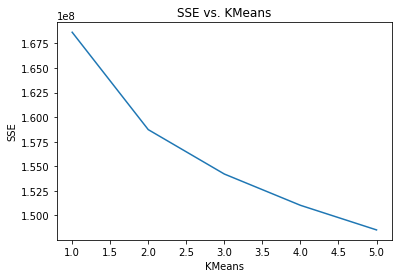

In [108]:
scores = []
#centers = list(range(1,20)) #too long to run
#centers = list(range(1,10)) #too long to run
#centers = list(range(1,3)) # too little
centers = list(range(1,6))
for center in centers:
    scores.append(get_kmeans_score(X_pca, center))
    
plt.plot(centers, scores);
plt.xlabel('KMeans');
plt.ylabel('SSE');
plt.title('SSE vs. KMeans')

Text(0.5, 1.0, 'SSE vs. KMeans')

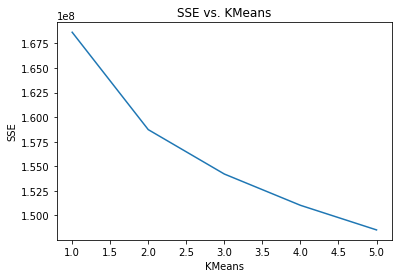

In [109]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
azk_3 = KMeans(n_clusters=6)
azmodel_3 = azk_3.fit(X_pca)
azlabels_3 = azmodel_3.predict(X_pca)

plt.plot(centers, scores);
plt.xlabel('KMeans');
plt.ylabel('SSE');
plt.title('SSE vs. KMeans')

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?) Due to the length of time to run the clustering, I maximized it at 6. Using 3 clusters produced a linear line. With 6, the elbow is still evident. The turning point or elbow is at 2 in SSE v KMeans where SSE slows. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

### Customers section

In [110]:
# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer 
# data, obtaining cluster predictions for the customer demographics data.
customers_clean = clean_data(customers)
customers_clean.shape

(141322, 212)

In [111]:
# Copying dataframe in case of issues later
customers_clean_cc = customers_clean.copy()

In [112]:
cust_clean_imputed = pd.DataFrame(imputer.transform(customers_clean), columns = lo_count_df.columns)

In [113]:
cust_clean_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,...,CAMEO_DEU_2015_9E,YOUTH_TASTE,NEIGHBORHOOD_average,NEIGHBORHOOD_good,NEIGHBORHOOD_new rural bldg,NEIGHBORHOOD_poor,NEIGHBORHOOD_rural,NEIGHBORHOOD_very good,NEIGHBORHOOD_very poor,DECADE_40s,DECADE_50s,DECADE_60s,DECADE_70s,DECADE_80s,DECADE_90s,BLDG_TYPE_1-2 family,BLDG_TYPE_10+ family,BLDG_TYPE_3-5 family,BLDG_TYPE_6-10 family,BLDG_TYPE_businesses,LIFE_STAGE_ELDERLY,LIFE_STAGE_OLDER,LIFE_STAGE_PRE,LIFE_STAGE_PRI,LIFE_STAGE_YOUNG
0,0.0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,5.0,6.0,5.0,2.0,6.0,6.0,7.0,3.0,4.0,1.0,3.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.0,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,5.0,2.0,2.0,1.0,3.0,3.0,7.0,7.0,1.0,2.0,7.0,5.0,6.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,3.0,6.0,5.0,3.0,4.0,7.0,5.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4.0,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,5.0,4.0,5.0,4.0,6.0,5.0,6.0,4.0,5.0,5.0,3.0,5.0,2.0,5.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5.0,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,3.0,6.0,4.0,4.0,1.0,7.0,6.0,4.0,6.0,2.0,5.0,5.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [114]:
customer_imputed_scaled = pd.DataFrame(scaler.transform(cust_clean_imputed), columns = cust_clean_imputed.columns) 

In [115]:
customer_imputed_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,...,CAMEO_DEU_2015_9E,YOUTH_TASTE,NEIGHBORHOOD_average,NEIGHBORHOOD_good,NEIGHBORHOOD_new rural bldg,NEIGHBORHOOD_poor,NEIGHBORHOOD_rural,NEIGHBORHOOD_very good,NEIGHBORHOOD_very poor,DECADE_40s,DECADE_50s,DECADE_60s,DECADE_70s,DECADE_80s,DECADE_90s,BLDG_TYPE_1-2 family,BLDG_TYPE_10+ family,BLDG_TYPE_3-5 family,BLDG_TYPE_6-10 family,BLDG_TYPE_businesses,LIFE_STAGE_ELDERLY,LIFE_STAGE_OLDER,LIFE_STAGE_PRE,LIFE_STAGE_PRI,LIFE_STAGE_YOUNG
0,-2.749492,4.961785,-1.493869,1.538298,-1.767506,1.466412,-1.183024,-0.795107,4.299299,-1.626278,-1.683982,0.441601,0.986784,0.527039,-0.984767,0.886713,0.790977,1.301350,-0.579014,0.064925,-2.017508,-0.851600,-1.763607,-1.715017,-0.977124,...,-0.089762,-1.874517,-0.675632,-0.379642,-0.148666,-0.453582,1.924699,-0.241480,-0.32064,-0.191265,3.118507,-0.409445,-0.530618,-0.484727,-0.627439,0.769911,-0.276989,-0.311604,-0.260994,-0.373383,-0.41507,-0.642580,-0.666781,2.379612,-0.327788
1,-0.782440,4.961785,-0.767972,1.538298,-1.767506,1.466412,-1.183024,0.626465,9.129299,-1.626278,-0.994637,0.441601,-1.104322,-1.043421,-1.507341,-0.656489,-0.635697,1.301350,1.463974,-1.749559,-1.448763,1.338893,0.377681,0.978197,0.155863,...,-0.089762,-1.874517,-0.675632,2.634057,-0.148666,-0.453582,-0.519562,-0.241480,-0.32064,-0.191265,3.118507,-0.409445,-0.530618,-0.484727,-0.627439,-1.298851,-0.276989,-0.311604,3.831507,-0.373383,-0.41507,1.556227,-0.666781,-0.420237,-0.327788
2,0.201085,4.961785,-1.493869,1.538298,-1.767506,1.466412,-0.467991,-1.505892,4.299299,-2.981748,-0.994637,-0.588718,0.986784,0.527039,-0.462193,-0.142088,1.266535,0.206403,-0.579014,0.064925,-0.880019,-0.851600,-0.692963,-0.637731,-0.410631,...,-0.089762,0.553085,-0.675632,-0.379642,-0.148666,-0.453582,1.924699,-0.241480,-0.32064,5.228358,-0.320666,-0.409445,-0.530618,-0.484727,-0.627439,0.769911,-0.276989,-0.311604,-0.260994,-0.373383,-0.41507,1.556227,-0.666781,-0.420237,-0.327788
3,1.184611,2.959955,-1.493869,0.191666,-1.767506,0.787359,0.962075,1.337250,4.299299,-2.981748,-0.305291,0.441601,-0.058769,0.527039,0.060382,0.886713,0.315419,0.753877,-0.068267,0.669753,0.257471,-0.851600,0.377681,-1.176374,0.722356,...,-0.089762,0.553085,1.480095,-0.379642,-0.148666,-0.453582,-0.519562,-0.241480,-0.32064,-0.191265,-0.320666,-0.409445,1.884596,-0.484727,-0.627439,-1.298851,-0.276989,3.209198,-0.260994,-0.373383,-0.41507,-0.642580,1.499742,-0.420237,-0.327788
4,2.168137,2.959955,-1.493869,1.538298,-1.767506,1.466412,-1.183024,-0.795107,6.714299,-1.626278,-0.305291,-0.588718,0.986784,0.003552,0.060382,-1.685290,1.266535,0.753877,-0.068267,1.274581,-1.448763,0.243646,0.377681,-0.637731,-0.410631,...,-0.089762,-1.874517,-0.675632,-0.379642,-0.148666,-0.453582,-0.519562,4.141131,-0.32064,-0.191265,3.118507,-0.409445,-0.530618,-0.484727,-0.627439,0.769911,-0.276989,-0.311604,-0.260994,-0.373383,-0.41507,1.556227,-0.666781,-0.420237,-0.327788


#### Customers PCA Section

In [116]:
customers_pca = pca.transform(customer_imputed_scaled)
# returns a numpy array

In [117]:
# for troubleshooting
np.size(customers_pca)

29960264

In [118]:
# delete, for troubleshooting
azk_3

KMeans(n_clusters=6)

In [119]:
# Troubleshooting
np.size(X_pca)

168639428

In [120]:
# If this works, maybe able to replace 2 below. delete
customers_cluster = azk_3.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

/Users/jenniferkrohn/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


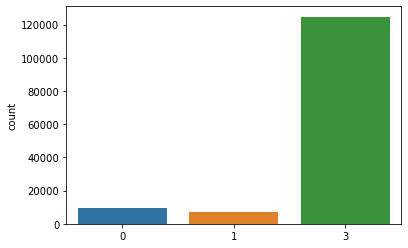

In [121]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
sns.countplot(customers_cluster, label='customer')

In [ ]:
# Porportion of the customer clusters
#labels, values = zip(*Counter(customers_cluster).items())
#v=list(values)
#v[:] = [x/len(customers_cluster) for x in v]
#indexes = np.arange(len(labels))
# source: https://knowledge.udacity.com/questions/905904

In [123]:
# 2nd attempt
# Porportion of the customer clusters
labels, values = zip(*Counter(customers_cluster).items())
v=list(values)
v[:] = [x/len(customers_cluster) for x in v]
#indexes = np.arange(len(labels))
# source: https://knowledge.udacity.com/questions/905904

In [ ]:
# Porportion of the azdias clusters.
#labels1, values1 = zip(*Counter(azlabels_3).items())
#v1=list(values1)
#v1[:] = [x/len(azlabels_3) for x in v1]
#indexes1 = np.arange(len(labels))

In [124]:
# 2nd attempt
# Porportion of the azdias clusters.
labels1, values1 = zip(*Counter(azlabels_3).items())
v1=list(values1)
v1[:] = [x/len(azlabels_3) for x in v1]
#indexes1 = np.arange(len(labels))
indexes = np.arange(len(labels))

In [ ]:
# troubleshooting ValueError: shape mismatch: objects cannot be broadcast to a single shape
np.size(azlabels_3)

In [ ]:
# troubleshooting 
np.size(customers_cluster)

In [ ]:
# troubleshooting 
len(indexes1) == len(v1)
# These are not matching, causing an issue now

In [ ]:
# troubleshooting 
len(labels) == len(labels1)

In [ ]:
# Graph
#width = .5
#plt.bar(indexes1, v1, width ,label='General')
#plt.bar(indexes+width, v, width,  color='r' , label='Customer')
#plt.xticks(indexes + width * 0.5, labels)
#plt.legend(loc='upper left')
#plt.grid()
#plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

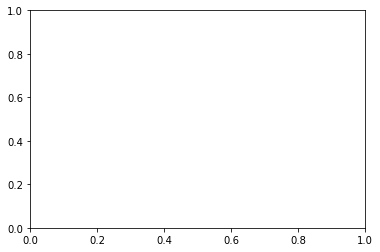

In [125]:
# 2nd attempt
# Graph
width = .5
#plt.bar(indexes1, v1, width ,label='General')
plt.bar(indexes, v1, width ,label='General')
plt.bar(indexes+width, v, width,  color='r' , label='Customer')
# plt.xticks(indexes + width * 0.5, labels)
plt.xticks(indexes + width / 2, labels)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [126]:
#  creating a dataframe from the transformed data w the org col names as keys & keeping features as values. 
def plot_compare(df, model, cluster):
    x = pd.DataFrame.from_dict(dict(zip(df.columns, pca.inverse_transform(model.cluster_centers_[cluster]))), 
                               orient='index').rename(
columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
# get the absolute value to avoid positive or negative influence    
    x['feature_values_abs'] = abs(x['feature_values'])
    pd.concat((x['feature_values'][:10], x['feature_values'][-10:]), axis=0).plot(kind='barh');
# Source: https://knowledge.udacity.com/questions/428591  
# Source: https://stackoverflow.com/questions/20340844/pandas-create-named-columns-in-dataframe-from-dict

In [127]:
over_rep = 1   # Cluster 1
under_rep = 0  # Cluster 0

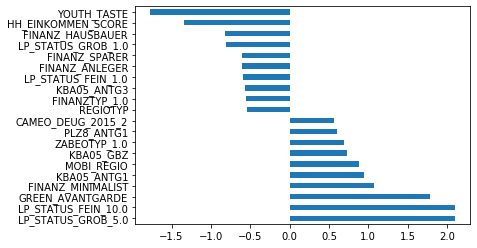

In [128]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# New DF of chosen cluster, inverse_transforms the PCA to retrieve the feature values
over_rep_df = pd.DataFrame.from_dict(dict(zip(customer_imputed_scaled.columns, pca.inverse_transform(azmodel_3.cluster_centers_[over_rep]))), orient='index').rename(
columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)

over_rep_df['feature_values_abs'] = abs(over_rep_df['feature_values'])
pd.concat((over_rep_df['feature_values'][:10], over_rep_df['feature_values'][-10:]), axis=0).plot(kind='barh');

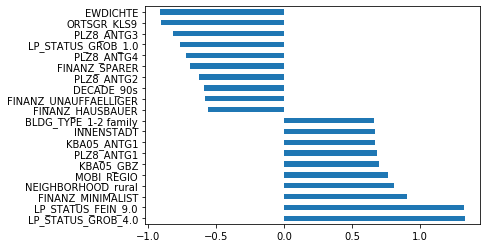

In [129]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_rep_df = pd.DataFrame.from_dict(dict(zip(customer_imputed_scaled.columns, pca.inverse_transform(azmodel_3.cluster_centers_[under_rep]))), orient='index').rename(
columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)

under_rep_df['feature_values_abs'] = abs(under_rep_df['feature_values'])
pd.concat((under_rep_df['feature_values'][:10], under_rep_df['feature_values'][-10:]), axis=0).plot(kind='barh');

### Discussion 3.3: Compare Customer Data to Demographics Data

The over represented segments are those from higher income households that own homes. The under respresented populations are those from denser living areas. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.